In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
datasets = ["Auslan", "Autos", "Car", "Cleveland", "Dermatology", "Ecoli", "Flare", "Glass", "Isolet", "Led7digit", "Letter-2", "Lymphography", "Nursery", "Page-blocks", "Penbased", "Satimage", "Segment", "Shuttle", "Vehicle", "Vowel", "Yeast", "Zoo"]
excluded_datasets = ['Letter-2']

datasets = [dataset for dataset in datasets if dataset not in excluded_datasets]

datasets_gte_7 = ['Ecoli', 'Led7digit', 'Penbased', 'Satimage', 'Segment', 'Shuttle', 'Vowel', 'Yeast', 'Zoo', 'Isolet', 'Letter-2', 'Auslan']
datasets_gte_7 = [dataset for dataset in datasets_gte_7 if dataset not in excluded_datasets]
datasets_lt_7 = [dataset for dataset in datasets if dataset not in datasets_gte_7]

results_folder = 'results'
experiment_1 = 'Experiment1'
experiment_2 = 'Experiment2'
experiment_3 = 'Experiment3'
metrics_folder = 'Metrics'

base_classifiers = ['svdd', 'parzen', 'kmeans']
aggregators = ['max_agg', 'decision_templates_agg', 'ecoc_agg']
techniques = ['des', 'desthr']
occ_strategies = ['ovo', 'ova']
occ_classifiers = ['svc', 'tree']

majority_agg = 'majority_agg'

accuracy = 'accuracy'
kappa = 'kappa'

acc_mean = 'acc_mean'
acc_std = 'acc_std'
kappa_mean = 'kappa_mean'
kappa_std = 'kappa_std'

k_levels = [0, 1, 3]

n_folds = 5

## Figure 8

In [3]:
desthr = techniques[1]

techniques_formatted = {
    'svdd_max_agg_desthr': 'MAX(SVDD)',
    'svdd_decision_templates_agg_desthr': 'DT(SVDD)',
    'svdd_ecoc_agg_desthr': 'ECOC(SVDD)',
    'parzen_max_agg_desthr': 'MAX(PDD)',
    'parzen_decision_templates_agg_desthr': 'DT(PDD)',
    'parzen_ecoc_agg_desthr': 'ECOC(PDD)',
    'kmeans_max_agg_desthr': 'MAX(KMEANS)',
    'kmeans_decision_templates_agg_desthr': 'DT(KMEANS)',
    'kmeans_ecoc_agg_desthr': 'ECOC(KMEANS)'
}

occ_techniques_formatted = {
    'svc_decision_templates_agg_ova_desthr' : 'DT(OVA+SVM)',
    'svc_decision_templates_agg_ovo_desthr' : 'DT(OVO+SVM)',
    'svc_ecoc_agg_ova_desthr' : 'ECOC(OVA+SVM)',
    'svc_ecoc_agg_ovo_desthr' : 'ECOC(OVO+SVM)',
    'svc_majority_agg_ovo_desthr' : 'MAX(OVO+SVM)',
    'svc_max_agg_ova_desthr' : 'MAX(OVA+SVM)',
    'tree_decision_templates_agg_ova_desthr' : 'DT(OVA+C4.5)',
    'tree_decision_templates_agg_ovo_desthr' : 'DT(OVO+C4.5)',
    'tree_ecoc_agg_ova_desthr' : 'ECOC(OVA+C4.5)',
    'tree_ecoc_agg_ovo_desthr' : 'ECOC(OVO+C4.5)',
    'tree_majority_agg_ovo_desthr' : 'MAX(OVO+C4.5)',
    'tree_max_agg_ova_desthr' : 'MAX(OVA+C4.5)'
}

In [4]:
def read_metrics_file(filename):
    return pd.read_csv(filename)

def get_results_filepath(result_folder, experiment, dataset, metrics_folder, metric_name):
    return './{}/{}/{}/{}/{}_{}.csv'.format(result_folder, experiment, dataset, metrics_folder, metric_name, dataset.lower())

In [5]:
def win_tie_loss_parser(value):
    if value > 0:
        return 'W'
    elif value < 0:
        return 'L'
    else:
        return 'T'

In [6]:
def gen_k_win_tie_loss(k, classifiers, aggs, dataset_names):
    global results_folder
    global experiment_1
    global experiment_2
    global metrics_folder
    global accuracy
    
    k_name = 'k{}'.format(k)

    techniques = []
    for base_classifier in classifiers:
        for aggregator in aggs:
            techniques.append('{}_{}_{}'.format(base_classifier, aggregator, desthr))
    techniques.sort()

    main_df = pd.DataFrame({'Technique': techniques})

    for dataset in dataset_names:
        ex1_filepath = get_results_filepath(results_folder, experiment_1, dataset, metrics_folder, accuracy)
        ex1_results = read_metrics_file(ex1_filepath)
        filtered_ex1 = ex1_results.loc[ex1_results['Technique'].isin(techniques)][['Technique', 'mean']].reset_index(drop=True)

        ex2_filepath = get_results_filepath(results_folder, experiment_2, dataset, metrics_folder, accuracy)
        ex2_results = read_metrics_file(ex2_filepath)
        filtered_ex2 = ex2_results.loc[ex2_results['Technique'] == k_name][['Technique', 'mean']].reset_index(drop=True)

        kwargs = {k_name : lambda x: filtered_ex2.iloc[0]['mean']}
        final_df = filtered_ex1.assign(**kwargs)
        final_df['W/T/L'] = final_df['mean'] - final_df[k_name]
        
        final_df.sort_values(by='Technique', inplace=True)
        final_df = final_df.reset_index(drop=True)
        main_df[dataset] = final_df['W/T/L'].apply(lambda x: win_tie_loss_parser(x))
        
    main_df['Wins'] = main_df[main_df[dataset_names] == 'W'].count(axis=1)
    main_df['Ties'] = main_df[main_df[dataset_names] == 'T'].count(axis=1)
    main_df['Losses'] = main_df[main_df[dataset_names] == 'L'].count(axis=1)

    return main_df

In [7]:
def knn_win_tie_loss_plot(df, title, xticks=[0, 5, 10, 15, 20, 22], xlim=(0, 22)):
    global techniques_formatted
    global results_folder
    global experiment_2
    
    wtl = df[['Technique', 'Wins', 'Ties', 'Losses']].copy()
    wtl['Technique'] = wtl['Technique'].apply(lambda x: techniques_formatted[x])
    
    wtl.sort_values(by='Technique', inplace=True)
    
    wtl.set_index('Technique', inplace=True)
    
    ax = wtl.plot.barh(stacked=True, color=['green', 'yellow', 'red'], legend=False, title=title, width=1, edgecolor = "black", xticks=xticks, xlim=xlim)
    ax.set_xlabel("no. of datasets")
    ax.set_ylabel("")
    
    fig = ax.get_figure()
    fig.savefig('{}/{}/{}.png'.format(results_folder, experiment_2, title), format='png', dpi=1000, bbox_inches='tight')

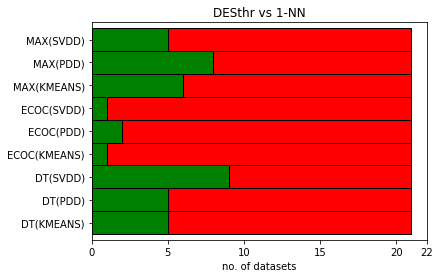

In [8]:
df_k0 = gen_k_win_tie_loss(0, base_classifiers, aggregators, datasets)
df_k0.to_csv('{}/{}/{}.csv'.format(results_folder, experiment_2, 'DESthr vs 1-NN'), index=False)
knn_win_tie_loss_plot(df_k0, 'DESthr vs 1-NN')

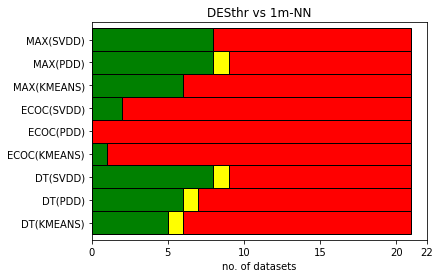

In [9]:
df_k1 = gen_k_win_tie_loss(1, base_classifiers, aggregators, datasets)
df_k1.to_csv('{}/{}/{}.csv'.format(results_folder, experiment_2, 'DESthr vs 1m-NN'), index=False)
knn_win_tie_loss_plot(df_k1, 'DESthr vs 1m-NN')

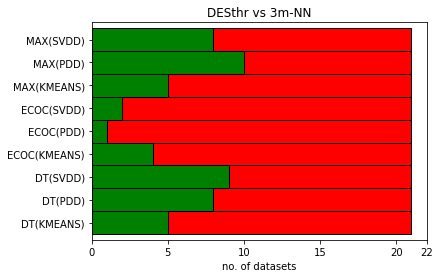

In [10]:
df_k3 = gen_k_win_tie_loss(3, base_classifiers, aggregators, datasets)
df_k3.to_csv('{}/{}/{}.csv'.format(results_folder, experiment_2, 'DESthr vs 3m-NN'), index=False)
knn_win_tie_loss_plot(df_k3, 'DESthr vs 3m-NN')

In [11]:
def get_classifiers_results(dataset_names):
    global results_folder
    global experiment_1
    global metrics_folder
    global accuracy
    global desthr
    global base_classifiers
    global aggregators
    global n_folds

    techniques = []
    for base_classifier in base_classifiers:
        for aggregator in aggregators:
            techniques.append('{}_{}_{}'.format(base_classifier, aggregator, desthr))
    
    columns = ['Technique']
    fold_columns = []
    for i in range(1, n_folds+1):
        fold_columns.append('Fold{}'.format(i))
    
    columns += fold_columns

    techniques.sort()

    main_df = {}

    for dataset in dataset_names:
        ex1_filepath = get_results_filepath(results_folder, experiment_1, dataset, metrics_folder, accuracy)
        ex1_results = read_metrics_file(ex1_filepath)
        filtered_ex1 = ex1_results.loc[ex1_results['Technique'].isin(techniques)][columns].reset_index(drop=True)
        filtered_ex1.set_index('Technique', inplace=True)
        
        for technique in techniques:
            label = techniques_formatted[technique]
            if label not in main_df:
                main_df[label] = []
            main_df[label] += list(filtered_ex1.loc[technique, :].dropna().values)

    return main_df

In [12]:
def get_classifiers_results_occ(dataset_names):
    global results_folder
    global experiment_3
    global metrics_folder
    global accuracy
    global desthr
    global aggregators
    global n_folds

    techniques = []
    for occ_classifier in occ_classifiers:
        for occ_strategy in occ_strategies:
            for aggregator in aggregators:
                if occ_strategy == 'ovo' and aggregator == 'max_agg':
                    techniques.append('{}_majority_agg_{}_{}'.format(occ_classifier, occ_strategy, desthr))
                else:
                    techniques.append('{}_{}_{}_{}'.format(occ_classifier, aggregator, occ_strategy, desthr))

    columns = ['Technique']
    fold_columns = []
    for i in range(1, n_folds+1):
        fold_columns.append('Fold{}'.format(i))

    columns += fold_columns

    techniques.sort()

    main_df = {}

    for dataset in dataset_names:
        ex1_filepath = get_results_filepath(results_folder, experiment_3, dataset, metrics_folder, accuracy)
        ex1_results = read_metrics_file(ex1_filepath)
        filtered_ex1 = ex1_results.loc[ex1_results['Technique'].isin(techniques)][columns].reset_index(drop=True)
        filtered_ex1.set_index('Technique', inplace=True)
        
        for technique in techniques:
            label = occ_techniques_formatted[technique]
            if label not in main_df:
                main_df[label] = []
            try:
                main_df[label] += list(filtered_ex1.loc[technique, :].dropna().values)
            except:
                pass

    return main_df

In [13]:
def get_by_agg(results, agg_name, formatted):
    names = [technique for technique in formatted.values() if agg_name in technique]
    
    filtered = {}
    for key in results.keys():
        if key in names:
            filtered[key] = results[key]
    return filtered

In [14]:
classifiers_results = get_classifiers_results(datasets_gte_7)
classifiers_results2 = get_classifiers_results(datasets_lt_7)

In [15]:
classifiers_results_occ = get_classifiers_results_occ(datasets_gte_7)
classifiers_results_occ2 = get_classifiers_results_occ(datasets_lt_7)

In [16]:
matplotlib.rcParams.update({'font.size': 14})
def boxplot_experiment3(results, results_occ, agg_label, title):
    global techniques_formatted
    global occ_techniques_formatted
    
    max_ = get_by_agg(results, agg_label, techniques_formatted)
    max2_ = get_by_agg(results_occ, agg_label, occ_techniques_formatted)
    merged = {**max_, **max2_}

    data = merged.values()
    labels = list(map(lambda x: x.replace('{}('.format(agg_label), '').replace(')', ''), merged.keys()))

    fig, ax = plt.subplots()
    ax.set_title(title)
    bplot = ax.boxplot(merged.values(), patch_artist=True)
    ax.set_xticklabels(labels, rotation = 90)
    ax.set_ylabel('accuracy [%]')
    ax.set_ylim((-0.05, 1.05))
    
    # fill with colors
    colors = ['green', 'red', 'blue', 'darkorange', 'khaki', 'royalblue', 'lightsteelblue']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.savefig('{}/{}/{}.png'.format(results_folder, experiment_3, title.replace('>=', 'gte').replace('<', 'lt').replace('.', '')), format='png', dpi=1000, bbox_inches='tight')
    plt.show()

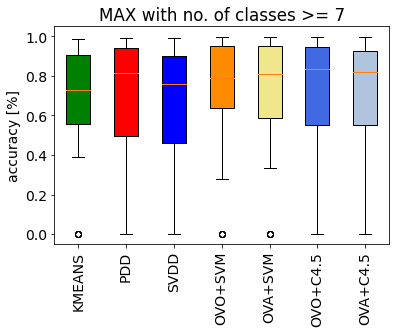

In [17]:
boxplot_experiment3(classifiers_results, classifiers_results_occ, 'MAX', 'MAX with no. of classes >= 7')

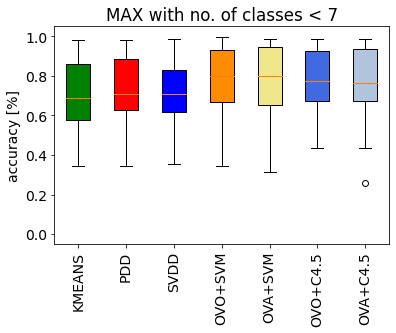

In [18]:
boxplot_experiment3(classifiers_results2, classifiers_results_occ2, 'MAX', 'MAX with no. of classes < 7')

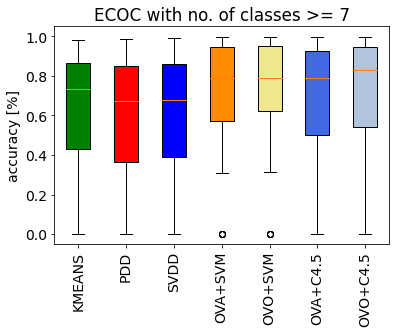

In [19]:
boxplot_experiment3(classifiers_results, classifiers_results_occ, 'ECOC', 'ECOC with no. of classes >= 7')

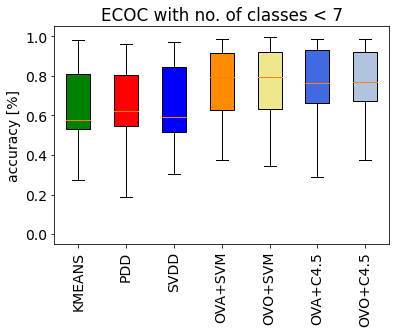

In [20]:
boxplot_experiment3(classifiers_results2, classifiers_results_occ2, 'ECOC', 'ECOC with no. of classes < 7')

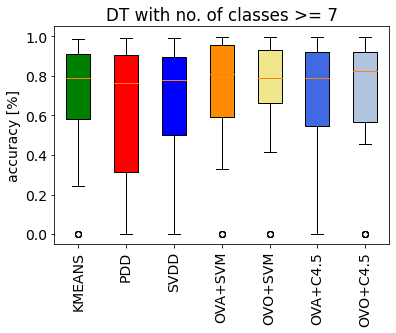

In [21]:
boxplot_experiment3(classifiers_results, classifiers_results_occ, 'DT', 'DT with no. of classes >= 7')

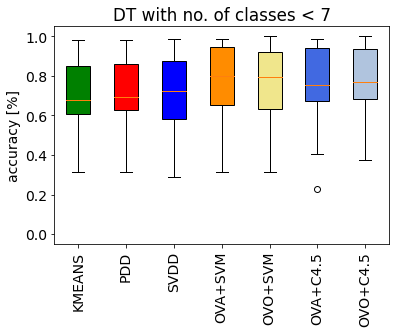

In [22]:
boxplot_experiment3(classifiers_results2, classifiers_results_occ2, 'DT', 'DT with no. of classes < 7')